In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  6 14:43:40 2023

@author: Katharina
"""
import os
import numpy as np
from pyplr import utils
import pandas as pd
from classPLRfromGitHub import PLR
from pyplr import graphing
from pyplr import preproc
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import simpledialog
import sys

/
    .DS_Store
    PLR_left_2d_results.csv
    PLR_left_3d_results.csv
    PLR_right_2d_results.csv
    PLR_right_3d_results.csv
    annotation_timestamps.npy
exports/
    .DS_Store
    000/
        annotations.csv
        export_info.csv
        gaze_positions.csv
        pupil_gaze_positions_info.txt
        pupil_positions.csv
        pupil_positions.csv.pickle
pyplr_analysis/
************************************************************
*****************************  *****************************
************************************************************
Loaded 8807 samples
Loaded 8807 samples
Loaded 4 events
Extracted ranges for 4 events
             eye_id  confidence   diameter  method      orig_idx  color
event onset                                                            
0     0           1    0.572564  19.079088  2d c++  15857.212941    NaN
      1           1    0.000000   0.000000  2d c++  15857.228358    NaN
      2           1    0.591773  30.422747  2d c++  15857.2

TypeError: mean() got an unexpected keyword argument 'level'

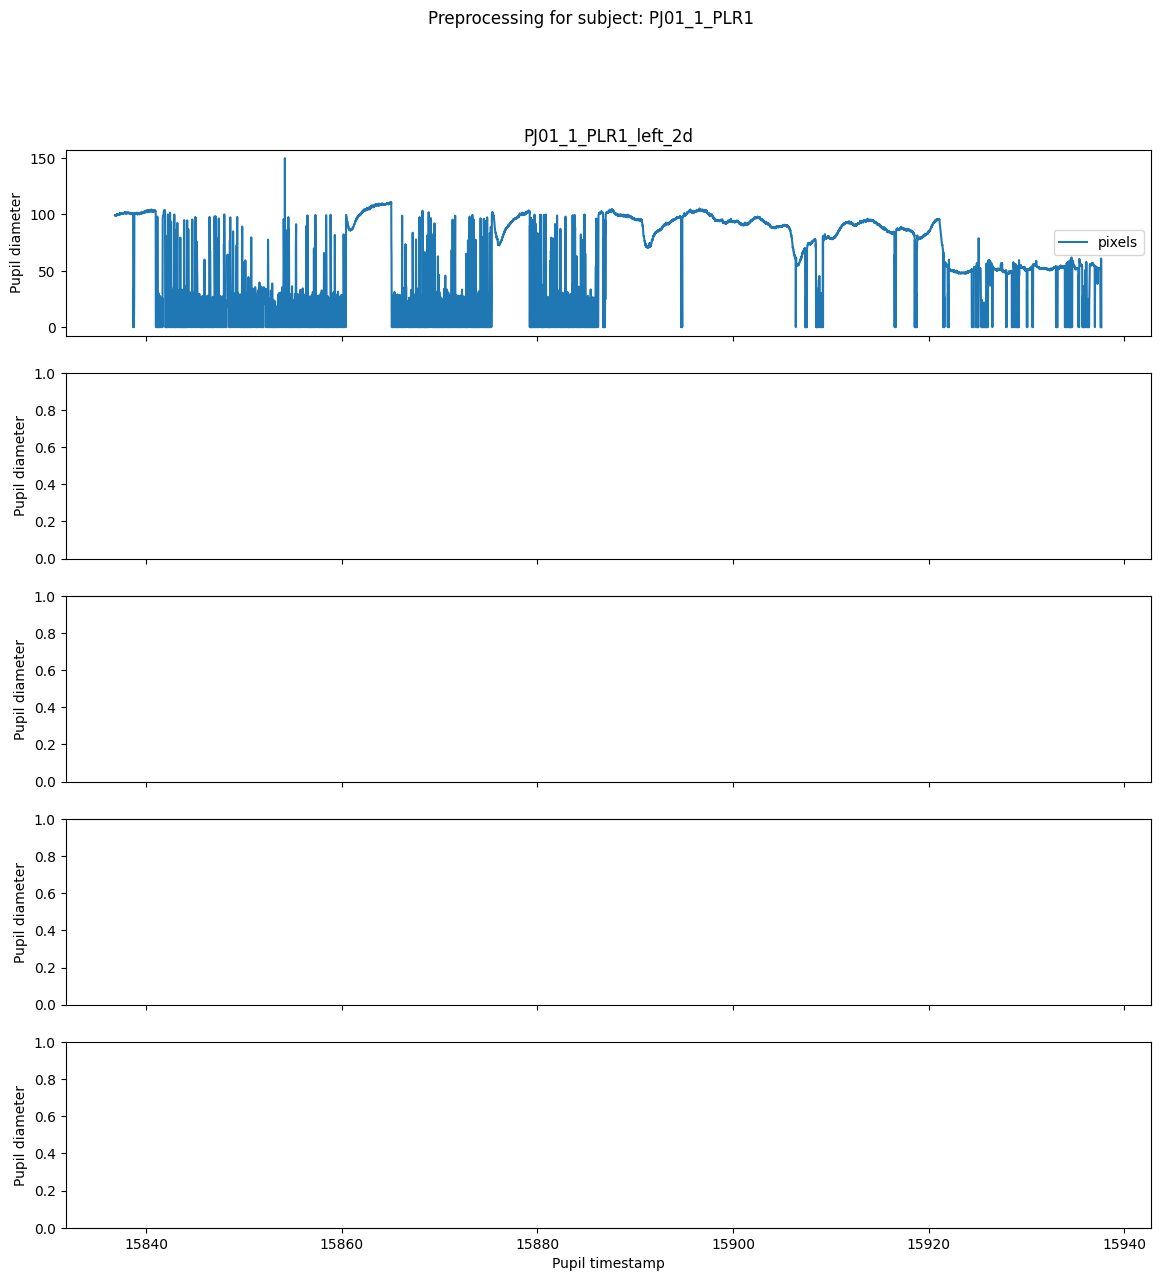

In [14]:
 #Load the data from the pupil player
# Pupil Labs recording directory
# Load the CSV file

subject_id='PJ01_1_PLR1'
rec_dir = f"/Users/Katharina/Desktop/Beispieldaten/{subject_id[:4]}/{subject_id}/"
utils.print_file_structure(rec_dir)

# define the patient ID for the dataframe and assign the 4 light strenghts


Light_strenght_1 = 1
Light_strenght_2 = 2
Light_strenght_3 = 3
Light_strenght_4 = 4


# Columns to load
use_cols = ['confidence',
            'method',
            'pupil_timestamp',
            'eye_id',
            'diameter']

pupil_cols = ['diameter']

# Check if the pyplr_analysis directory exists
if not os.path.exists(os.path.join(rec_dir, 'pyplr_analysis')):
    # Create the directory if it doesn't exist
    os.makedirs(os.path.join(rec_dir, 'pyplr_analysis'))

# Get a handle on a subject
s = utils.new_subject(
    rec_dir, export='000', out_dir_nm='pyplr_analysis')

# Load pupil data, method has to be changed to '3d' otherwise multiple repeat error
#eye_id=best takes the eye with the best confidence, eye_id=0 takes right, 1 takes left
samples = utils.load_pupil(
    s['data_dir'], eye_id='left', method='2d', cols=use_cols)
samples

# Sampling frequency
SAMPLE_RATE = 120


# load the pupil data for the current combination of eye_id and method
samples = utils.load_pupil(s['data_dir'], eye_id='left', method='2d', cols=use_cols)


# Make figure for processing, append figure to pupil_preprocessing
f, axs = graphing.pupil_preprocessing_figure(nrows=5, subject=f"{subject_id}" )
# Plot the raw data
# Plot the raw data
samples[pupil_cols].plot(title=f"{subject_id}_left_2d", ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['pixels'])


events = utils.load_annotations(s['data_dir'])
events

# Number of samples to extract and which sample
# should mark the onset of the event
# 120 data points equal one second with a sample rate of 120 
# Real duration is Duration-ONSET_IDX, example 240 equals 1 second
#ONSET_IDX is the time before light stimulus that gets sampled 
DURATION = 1200
ONSET_IDX = 120


# Extract the event ranges, gets range of total of Duration (720)
#and shifts it Onset_idx to the left in time, therefore 120 is the 0 point
ranges = utils.extract(
    samples,
    events,
    offset=-ONSET_IDX,
    duration=DURATION,
    borrow_attributes=['color'])
ranges

# Calculate baselines, the time before the onset is 0 to 120  
#baselines = ranges.loc[:, range(0, ONSET_IDX), :].mean(level=0)

# New columns for percent signal change, simply adds 2 new columns
# with percent change 
#ranges = preproc.percent_signal_change(
#    ranges, baselines, pupil_cols)
#ranges

ranges.index
print(ranges.loc[0:3])
 
ranges1 = ranges.loc[0]
ranges2 = ranges.loc[1]  
ranges3 = ranges.loc[2]
ranges4 = ranges.loc[3]   

print(ranges4)



# function to get the average plr from the input_range 


def get_average_plr(input_range):
    average_plr = input_range.mean(level=1)['diameter'].to_numpy()
    return PLR(average_plr,
              sample_rate=SAMPLE_RATE,
              onset_idx=ONSET_IDX,
              stim_duration=1)

plr1 = get_average_plr(ranges1)
plr2 = get_average_plr(ranges2)
plr3 = get_average_plr(ranges3)
plr4 = get_average_plr(ranges4)

plr_all = [plr1, plr2, plr3, plr4]

#plot graphs for vel = velocity in green, acc = acceleration in red and parameters
fig1 = plr1.plot(vel=True, acc=True, print_params=True)
fig2 = plr2.plot(vel=True, acc=True, print_params=True)
fig3 = plr3.plot(vel=True, acc=True, print_params=True)
fig4 = plr4.plot(vel=True, acc=True, print_params=True)

params1 = plr1.parameters()
params1

params2 = plr2.parameters()
params2

params3 = plr3.parameters()
params3

params4 = plr4.parameters()
params4

 


def get_pyplr_results(plr):
#D1 = baseline pupilsize, in mm
    D1 = plr.baseline()
    print("D1: ",D1)
    
    #D2 = minimum pupilsize, in mm 
    D2 = plr.peak_constriction()
    print("D2: ",D2)
    
    #AMP = constriction amplitude, in mm
    AMP = D1-D2
    print("AMP: ",AMP)
    
    #VCmax = maximum velocity of constriction, in mm/s
    VCmax = plr.max_constriction_velocity()
    print("VCmax: ",VCmax)
    
    #ACmax = maximum acceleration, in mm/s ?
    ACmax = plr.max_constriction_acceleration()
    print("ACmax: ",ACmax)
    
    #T1 = latency from the onset of the light stimulus to the maximum acceleration
    # in milliseconds - looks like in seconds on the graph  
    T1 = plr.latency_to_constriction_b()
    print("T1: ",T1)
    
    #T2 = time to maximum velocity, looks like in seconds on the graph 
    T2 = plr.time_to_max_velocity()
    print("T2: ",T2)
    
    #T3 = time to maximum constriction, in milliseconds - looks like in seconds on graph 
    T3 = plr.time_to_max_constriction()
    print("T3: ",T3)
    
    #relative constriction amplitude: AMP/D1
    rel_AMP = AMP/D1
    print("rel_AMP: ", rel_AMP)
    
    #time to 75% redilation 
    redil_75 = plr.time_to_75pc_recovery()
    print("redil_75", redil_75)
    
    #time to 50% redilation
    redil_50 = plr.time_to_50pc_recovery()
    print('redil_50', redil_50)
    
    redil_25 = plr.time_to_25pc_recovery()
    print('redil_25', redil_25)
    
    # create a CSV file
    return {
            'D1':D1,
            'D2': D2,
            'AMP': AMP,
            'VCmax':VCmax,
            'ACmax': ACmax,
            'T1': T1,
            'T2':T2,
            'T3':T3,
            "rel_AMP": rel_AMP,
            "redil_75": redil_75,
            'redil_50': redil_50,
            'redil_25': redil_25
            }

pyplr_results = {'Subject ID': [subject_id, subject_id, subject_id, subject_id],
                 'D1':[],
                 'D2':[],
                 'AMP': [],
                 'VCmax':[],
                 'ACmax': [],
                 'T1': [],
                 'T2':[],
                 'T3':[],
                 "rel_AMP": [],
                 "redil_75": [],
                 'redil_50': [],
                 'redil_25': [],
                 'Light_strenght': [Light_strenght_1, Light_strenght_2, Light_strenght_3, Light_strenght_4],
         }
#pyplr_results = pd.DataFrame([ID, D1, D2, AMP. VCmax, ACmax, T1, T2, T3, Light_strenght], columns=["ID", "D1", "D2", "AMP", "VCmax", "ACmax", "T1", "T2", "T3", "Light_strenght"])

for plr in plr_all:
    pyplr_result = get_pyplr_results(plr)
    pyplr_results["D1"].append(pyplr_result["D1"])
    pyplr_results["D2"].append(pyplr_result["D2"])
    pyplr_results["AMP"].append(pyplr_result["AMP"])
    pyplr_results["VCmax"].append(pyplr_result["VCmax"])
    pyplr_results["ACmax"].append(pyplr_result["ACmax"])
    pyplr_results["T1"].append(pyplr_result["T1"])
    pyplr_results["T2"].append(pyplr_result["T2"])
    pyplr_results["T3"].append(pyplr_result["T3"])
    pyplr_results["rel_AMP"].append(pyplr_result["rel_AMP"])
    pyplr_results["redil_75"].append(pyplr_result["redil_75"])
    pyplr_results["redil_50"].append(pyplr_result["redil_50"])
    pyplr_results["redil_25"].append(pyplr_result["redil_25"])


df = pd.DataFrame(pyplr_results)
df["eye_id"] = "1"
df["method"] = "2d"


#always change the directory to what the sample gets saved 
df.to_csv(f"/Users/Katharina/Desktop/Beispieldaten/{subject_id[:4]}/{subject_id}/PLR_left_2d_results.csv", index=False)

print(df)

